# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [2]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [3]:
def count_info_gain(r_v, r_left, r_right):
    left, right = len(r_left) / len(r_v), len(r_right) / len(r_v)
    return entropy(r_v) - left * entropy(r_left) - right * entropy(r_right)


class Node:
    def __init__(self, probabilities=None):
        self.right = None
        self.left = None
        self.probabilities = probabilities
        self.feature_index = None
        self.t = -1


class DecisionTreeClassifier:
    def __init__(
        self,
        max_depth: int = 5,
        min_samples_leaf: int = 5,
    ):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = None
        self.tree = None

    def probabilities(self, y):
        return np.array([len(y[y == y_type]) / len(y) for y_type in range(self.n_classes)])

    def _is_stop_condition(self, y, depth, leaf_samples):
        over_depth = depth >= self.max_depth
        not_enough_samples = len(y) < leaf_samples
        purity = len(np.unique(y)) == 1
        return over_depth or not_enough_samples or purity

    def split_node(self, X, y, node, depth=0):
        if self._is_stop_condition(y, depth, self.min_samples_leaf):
            return

        feature_index, best_t = self._find_best_split(X, y)
        if feature_index is None:
            return

        x_left, y_left = X[X[:, feature_index] < best_t], y[X[:, feature_index] < best_t]
        x_right, y_right = X[X[:, feature_index] >= best_t], y[X[:, feature_index] >= best_t]

        node.left = Node(self.probabilities(y_left))
        node.right = Node(self.probabilities(y_right))
        node.feature_index = feature_index
        node.t = best_t
        self.split_node(x_left, y_left, node.left, depth + 1)
        self.split_node(x_right, y_right, node.right, depth + 1)


    @staticmethod
    def _find_best_split(X, y):
        best_idx, best_thr, best_ig = None, None, -1
        for i in range(X.shape[1]):
            x_col = X[:, i]
            for t in x_col:
                r_left, r_right = y[x_col < t], y[x_col >= t]
                ig = count_info_gain(y, r_left, r_right)
                if ig > best_ig:
                    best_thr, best_ig, best_idx = t, ig, i

        return best_idx, best_thr

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.tree = Node(self.probabilities(y))
        self.split_node(np.asarray(X), y, self.tree)

    def predict(self, X):
        return [np.argmax(self.predict_node(x, self.tree)) for x in X]

    def predict_node(self, x, node):
        while node.left:
            if x[node.feature_index] < node.t:
                return self.predict_node(x, node.left)
            else:
                return self.predict_node(x, node.right)

        return node.probabilities

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

decision_tree = DecisionTreeClassifier(max_depth=5)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

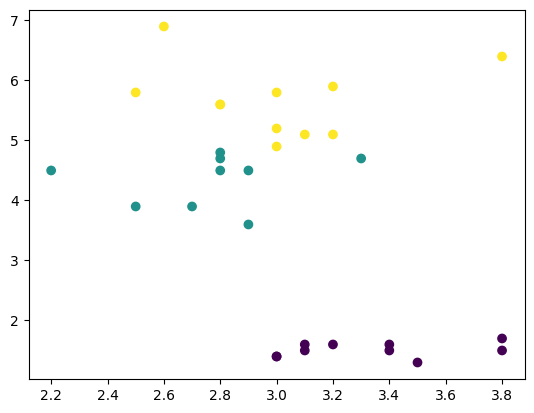

In [6]:
plt.scatter(X_test[:, 1], X_test[:, 2], c=y_pred)

In [7]:
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier

sklearn_decision_tree = SklearnDecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
sklearn_decision_tree.fit(X_train, y_train)
y_pred = sklearn_decision_tree.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

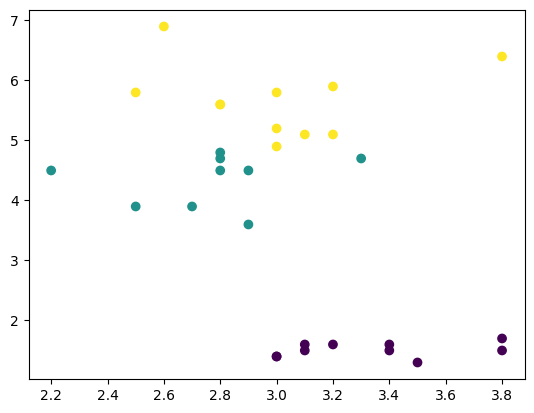

In [8]:
plt.scatter(X_test[:, 1], X_test[:, 2], c=y_pred)

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [9]:
# ...